# Polish companies bankruptcy data
## https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
Датасет содержит финансовые данные о польских компаниях, собранные с Emerging Markets Information Service (EMIS). Задача: предсказать банкротство компании.

In [1]:
# базовые импорты
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import subprocess
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # загрузка датасета
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip
# !unzip data.zip

### Чтение и получение основных хар-к

In [3]:
# получаем список файлов датасета
r = subprocess.run(['ls'], stdout=subprocess.PIPE)
all_files = str(r.stdout, encoding='utf-8')[:-1].split('\n')
data_files = []
for el in all_files:
    if el.endswith('.arff'):
        data_files.append(el)
print("Dataset files:", data_files)

Dataset files: ['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']


Датасет состоит из пяти файлов:
- 1year.arff содержит финансовые данные первого года из периода наблюдения и соотвествующих меток класса, которые сообщают о статусе банкротства через 5 лет (0 - компания продолжила работать, 1 - обанкротилась).
- 2year.arff содержит данные второго года и статус банкротства через 4 года
- 3year.arff содержит данные третьего года и статус банкротства через 3 года
- и т.д.

Файлы можно читать как обычный CSV, пропустив первые 69 строк.

В этом ноутбуке будет использоваться файл 3year.arff.

Описания/имена колонок были скопированы с описания датасета: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [4]:
columns = '''X1 net profit / total assets
X2 total liabilities / total assets
X3 working capital / total assets
X4 current assets / short-term liabilities
X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
X6 retained earnings / total assets
X7 EBIT / total assets
X8 book value of equity / total liabilities
X9 sales / total assets
X10 equity / total assets
X11 (gross profit + extraordinary items + financial expenses) / total assets
X12 gross profit / short-term liabilities
X13 (gross profit + depreciation) / sales
X14 (gross profit + interest) / total assets
X15 (total liabilities * 365) / (gross profit + depreciation)
X16 (gross profit + depreciation) / total liabilities
X17 total assets / total liabilities
X18 gross profit / total assets
X19 gross profit / sales
X20 (inventory * 365) / sales
X21 sales (n) / sales (n-1)
X22 profit on operating activities / total assets
X23 net profit / sales
X24 gross profit (in 3 years) / total assets
X25 (equity - share capital) / total assets
X26 (net profit + depreciation) / total liabilities
X27 profit on operating activities / financial expenses
X28 working capital / fixed assets
X29 logarithm of total assets
X30 (total liabilities - cash) / sales
X31 (gross profit + interest) / sales
X32 (current liabilities * 365) / cost of products sold
X33 operating expenses / short-term liabilities
X34 operating expenses / total liabilities
X35 profit on sales / total assets
X36 total sales / total assets
X37 (current assets - inventories) / long-term liabilities
X38 constant capital / total assets
X39 profit on sales / sales
X40 (current assets - inventory - receivables) / short-term liabilities
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
X42 profit on operating activities / sales
X43 rotation receivables + inventory turnover in days
X44 (receivables * 365) / sales
X45 net profit / inventory
X46 (current assets - inventory) / short-term liabilities
X47 (inventory * 365) / cost of products sold
X48 EBITDA (profit on operating activities - depreciation) / total assets
X49 EBITDA (profit on operating activities - depreciation) / sales
X50 current assets / total liabilities
X51 short-term liabilities / total assets
X52 (short-term liabilities * 365) / cost of products sold)
X53 equity / fixed assets
X54 constant capital / fixed assets
X55 working capital
X56 (sales - cost of products sold) / sales
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
X58 total costs / total sales
X59 long-term liabilities / equity
X60 sales / inventory
X61 sales / receivables
X62 (short-term liabilities *365) / sales
X63 sales / short-term liabilities
X64 sales / fixed assets'''

columns = [el[(3 + int(i >= 9)):] for i, el in enumerate(columns.split('\n'))] + ['bankruptcy']

In [5]:
# чтение данных
data = pd.read_csv(data_files[2], skiprows=69, header=None, names=columns, na_values='?', dtype=np.float64)
data[['bankruptcy']] = data[['bankruptcy']].astype(np.int32)
print('Data shape:', data.shape)

Data shape: (10503, 65)


Большинство фич датасета является отношением каких-либо двух финансовых показателей, исключениями являются logarithm of total assets (логарифм от общих активов) и working capital.

In [6]:
# описание первых двадцати фич
data.describe().T[:20]

,count,mean,std,min,25%,50%,75%,max
net profit / total assets,10503.0,0.052844,0.647797,-1.769200e+01,0.000686,0.043034,0.123805,5.265200e+01
total liabilities / total assets,10503.0,0.619911,6.427041,0.000000e+00,0.253955,0.464140,0.689330,4.807300e+02
working capital / total assets,10503.0,0.095490,6.420056,-4.797300e+02,0.017461,0.198560,0.419545,1.770800e+01
current assets / short-term liabilities,10485.0,9.980499,523.691951,2.080200e-03,1.040100,1.605600,2.959500,5.343300e+04
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,10478.0,-1347.662372,118580.569222,-1.190300e+07,-52.070750,1.579300,56.084000,6.854400e+05
retained earnings / total assets,10503.0,-0.121159,6.970625,-5.081200e+02,0.000000,0.000000,0.072584,4.553300e+01
EBIT / total assets,10503.0,0.065624,0.651152,-1.769200e+01,0.002118,0.050945,0.142275,5.265200e+01
book value of equity / total liabilities,10489.0,19.140113,717.756745,-2.081800e+00,0.431270,1.111000,2.857100,5.343200e+04
sales / total assets,10500.0,1.819254,7.581659,-1.215700e+00,1.011275,1.199000,2.059100,7.404400e+02
equity / total assets,10503.0,0.366093,6.428603,-4.797300e+02,0.297340,0.515500,0.725635,1.183700e+01


Наблюдается большой дисбаланс между классами 

In [7]:
cls_count = data[['bankruptcy']].value_counts()
print(cls_count)
print('Процент обанкротившихся компаний:', int(cls_count[1]) / (sum(cls_count)) * 100)

bankruptcy
0             10008
1               495
dtype: int64
Процент обанкротившихся компаний: 4.712939160239932


Построим матрицу корреляции, но только для двадцати фич, у которых сумма квадратов корреляции максимальна, т.к. все 64 не влезут в рисунок.
В основном, коррелируют только пары фич, которые связаны общими фин. показателями в отношении.

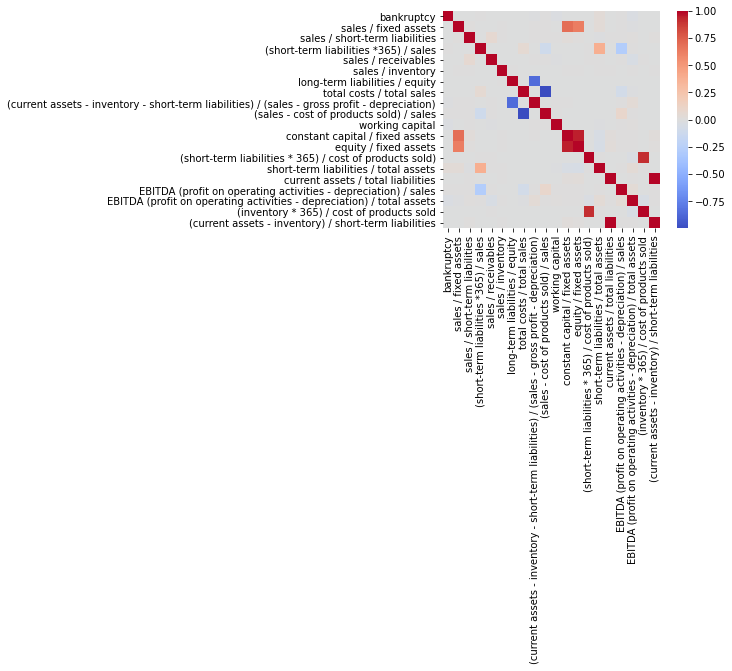

In [8]:
# будем исключать корреляции пар фич, которые базируются на хотя бы одном одинаковом фин. показателе
def cols_has_same_fin_rate(col_1, col_2):
    col_1, col_2 = set(col_1.split(' / ')), set(col_2.split(' / '))
    if len(col_1.union(col_2)) > 0:
        return True
    else:
        return False


def build_corr_matrix(data_frame):
    corr_matrix = data_frame.corr()
    corr_sums = {}
    for col_i in list(data_frame.columns):
        corr_sum = 0
        for col_j in list(data_frame.columns):
            if col_i == col_j or cols_has_same_fin_rate(col_i, col_j):
                continue
            corr_sum += corr_matrix[col_j][col_i] ** 2
        corr_sums.update({col_i: corr_sum})
    corr_sums = dict(sorted(corr_sums.items(), key=lambda x: x[1])[::-1])
    selected_features = list(corr_sums.keys())[:20]
    sb.heatmap(corr_matrix.loc[selected_features, selected_features], square=True, cmap='coolwarm')


build_corr_matrix(data)

В датасете присутствуют NaN'ы, причем в некоторых фичах их кол-во доходит почти до половины от всех значений.

In [9]:
def print_df_nan_counts(data_frame):
    print([sum(data_frame[col].isna()) for col in list(data_frame.columns)])

print('NaN count in features:')
print_df_nan_counts(data)

NaN count in features:
[0, 0, 0, 18, 25, 0, 0, 14, 3, 0, 0, 18, 43, 0, 8, 14, 14, 0, 43, 43, 807, 0, 43, 227, 0, 14, 715, 228, 0, 43, 43, 101, 18, 14, 0, 0, 4736, 0, 43, 18, 202, 43, 43, 43, 591, 18, 86, 0, 43, 14, 0, 86, 228, 228, 0, 43, 0, 29, 0, 592, 17, 43, 18, 228, 0]


Заполняем NaN'ы медианами

In [10]:
data.fillna(data.median(axis=0), axis=0, inplace=True)

Т.к. большинство признаков безразмерны, а для kNN c Евклидовой дистанцией лучше избавиться от большого разброса значений между фичами, проведем нормализацию.

In [11]:
y = data[['bankruptcy']]
data = data.drop(columns=['bankruptcy'])
norm_data = (data - data.mean(axis = 0)) / data.std(axis = 0)

Разделим датасет на тренировочную и тестовую выборки.
Для оченки точности алгоритмов машинного обучения будем считать false negatives (когда банкротство не было предугадано) и false positives (когда выжившая компания была оценена как обанкроченная)

In [12]:
from sklearn.model_selection import train_test_split

def train_predict(alg_instance, data_frame, y, test_size=0.33, not_print=False):
    x, y = data_frame, y
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=42)
    alg_instance.fit(train_x, train_y)
    pred_y = alg_instance.predict(test_x)
    test_y = test_y.to_numpy().ravel()
    false_neg_acc = 0
    false_pos_acc = 0
    for i in range(test_y.shape[0]):
        if test_y[i] == 1 and pred_y[i] == 0:
            false_neg_acc += 1
        if test_y[i] == 0 and pred_y[i] == 1:
            false_pos_acc += 1
    if not not_print:
        print('{} false negatives of {} possible'.format(
            false_neg_acc, int(test_y.mean() * test_y.shape[0])))
        print('{} false positives of {} possible'.format(
            false_pos_acc, int(test_y.shape[0] - test_y.mean() * test_y.shape[0])))
    return false_neg_acc, int(test_y.mean() * test_y.shape[0]),\
           false_pos_acc, int(test_y.shape[0] - test_y.mean() * test_y.shape[0])

Как видно, kNN плохо подходит для решения задачи при любом кол-ве соседей, т.к. предсказанных банкротств очень мало или вообще нет

Maximum possible false negatives:  164


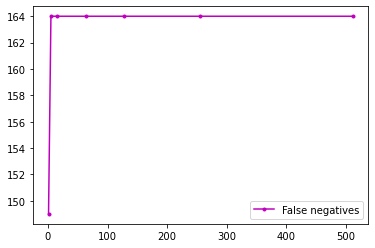

In [13]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 5, 16, 64, 128, 256, 512]
false_negs = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    false_neg, possible_false_neg, _, _ = train_predict(knn, norm_data, y, not_print=True)
    false_negs.append(false_neg)

print('Maximum possible false negatives: ', possible_false_neg)
plt.plot(ks, false_negs, '.-m', label = 'False negatives')
plt.legend(loc = 'best')

Даже использование гораздо более сложных случайного леса и градиентного бустинга не дает хорошие результаты

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as GBT
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF()
gbt = GBT()

print('RandomForestClassifier results:')
train_predict(rf, data, y)
print('')

print('GradientBoostingClassifier results:')
train_predict(gbt, data, y)
print('')

RandomForestClassifier results:
156 false negatives of 164 possible
5 false positives of 3302 possible

GradientBoostingClassifier results:
101 false negatives of 164 possible
6 false positives of 3302 possible



## Little feature engineering or information gain

Для того, чтобы улучшить результаты, можно попробовать получить еще немного информации из исходных данных:

Если многие фичи являются отношениями фин. показателей, то можно из этих отношений получить новые, т.е. из a/b и c/b получить a/с.

In [15]:
def gen_new_columns(col1, col2):
    col1, col2 = col1.split(' / '), col2.split(' / ')
    if len(col1) != 2 or len(col2) != 2:
        return ''
    if col1[1] == col2[1]:
        return col1[0] + ' / ' + col2[0]
    return ''

ext_data = data.copy()

for i, el_i in enumerate(columns):
    for j, el_j in enumerate(columns):
        if i == j:
            continue
        new_col = gen_new_columns(el_i, el_j)
        if new_col != '':
            ext_data[new_col] = ext_data[el_i] / ext_data[el_j]

ext_data.fillna(ext_data.median(axis=0), axis=0, inplace=True)

print('Размер нового дата фрейма:', ext_data.shape)

Размер нового дата фрейма: (10503, 522)


Теперь результаты градиентного бустинга стали гораздо лучше

In [16]:
print('GradientBoostingClassifier results:')
train_predict(gbt, ext_data, y)
print('')

GradientBoostingClassifier results:
22 false negatives of 164 possible
0 false positives of 3302 possible



## PCA

Сократим размерность до двух признаков

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_data = pca.fit_transform(norm_data)

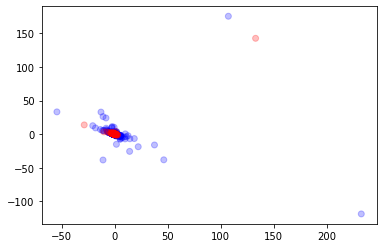

In [18]:
colors = ['r' if yy == 1 else 'b' for yy in y.values]
plt.scatter(new_data[:, 0], new_data[:, 1], color=colors, alpha=0.25)

SVM так же не является хорошим решение для задачи

In [19]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
train_predict(svc, new_data, y)

164 false negatives of 164 possible
0 false positives of 3302 possible


(164, 164, 0, 3302)

Попробуем варьировать число компонент, при этом смотря на точность решения задачи градиентным бустингом

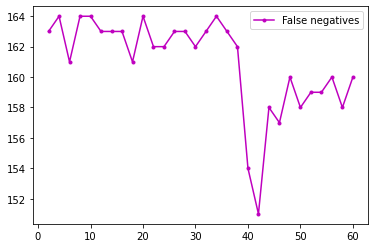

In [20]:
n_comps = list(range(2, norm_data.shape[1] - 2, 2))
false_negs = []
for nc in n_comps:
    pca = PCA(n_components=nc)
    new_data = pca.fit_transform(data)
    false_neg, possible_false_neg, _, _ = train_predict(gbt, new_data, y, not_print=True)
    false_negs.append(false_neg)

plt.plot(n_comps, false_negs, '.-m', label = 'False negatives')
plt.legend(loc = 'best')